In [4]:
! pip install cvxpy

/bin/bash: pip: command not found


<img src="latex0.png" width="420">
<img src="latex1.png" width="420">

In [5]:
import numpy as np
import cvxpy as cp
                                                                                
def motion_planner(obs_size = np.array(
                    [[10, 7.5, 2, 4,  10,  3,  2],
                     [7.5, 10, 2, 15, 1.5, 12, 4]]
                    ),
                    obs_lower = np.array(
                    [[-9.5, -9.5, -1.5, 1, -1.5, 5.5, 6],
                     [-9.5, -1,    1,  -7.5, 8, -9.5, 3]]
                    )):
    '''
    Inputs:
    
    obs_size:   2 x num_obs dimensional array, describing the width and height of obstacles. num_obs = # of obstacles
    obs_lower:  2 x num_obs dimensional array, describing the lower (south-western) corner of the obstacles

    Outputs:

    problem:    motion planning problem that can take starting position and goal position as parameters
    vars:       variables for the motion planning problem = [state trajectory, input trajectory, binary variables for obstacle avoidance]
    params:     parameters for the motion planning problem = [initial state, goal state]
    '''
# Obstacle "i" occupies the 2-dimensional interval: 
    # [obs_lower[:, i], obs_lower[:, i] + obs_size[:, i]]
    num_obs   = obs_size.shape[1]
    obs_upper = obs_lower + obs_size

#### Dynamics model data ####
    ## SEE SCREENSHOT 1 ##
    dt = 0.2
    A = np.matrix(
        [[1, 0, dt, 0],
         [0, 1, 0, dt],
         [0, 0, 1,  0],
         [0, 0, 0,  1]])
    
    B = dt * np.matrix(
        [[0, 0],
         [0, 0],
         [1, 0],
         [0, 1]])
    num_states = A.shape[1]
    num_inputs = B.shape[1]
    
#### Robot constraints ####
    ## SEE SCREENSHOT 2 ##
    Q = 1000 * np.identity(num_states)
    R = 50   * np.identity(num_inputs)
    N = 100

## State constraints
    # The robot state is subject to lower_x <= x_t <= upper_x
    lower_x = np.array([-1, -5, -1, -1])
    upper_x = np.array([20,  5,  1,  1])

    print(f"\nupper_x.shape = {upper_x.shape}\n")
        # robot must lie inside the rectangle with diagonally opposite points [-1, -5] and [10, 5]
        # robot's speed must be within -1 to 1 m/s in both X and Y directions
   
## Control constraints
    # The robot's control (accleration) is subject to lower_u <= u_t <= upper_u
    lower_u = np.array([-2, -2])
    upper_u = -lower_u

    # Declaring variables for state and input trajectories
    state = cp.Variable((num_states, N + 1)) # STATE IS X
    input = cp.Variable((num_inputs, N))     # INPUT IS U

    # Declare parameters
    state0 = cp.Parameter(num_states)
    goal   = cp.Parameter(num_states) 

#### Obstacle avoidance ####

    # Declaring binary variables for obstacle avoidance formulation
    boxes_low = [cp.Variable((2, N), boolean=True) for _ in range(num_obs)] # BOXES_LOW IS B_L
    boxes_upp = [cp.Variable((2, N), boolean=True) for _ in range(num_obs)] # BOXES_UPP IS B_U
    
    # big-M parameter
    M = np.diag([2 * upper_x[0], 2 * upper_x[1]])
    
    # Motion planning problem setup
    constraints = [state[:, 0] == state0]   # initial condition constraint
    objective = 0
    
    for k in range(N):
        ## SEE SCREENSHOT 1 ##
        # @ is matrix (dot) multiplication
        constraints += [state[:, k + 1] == A @ state[:, k] + B @ input[:, k]] # adding dynamics constraints
          
        constraints += [lower_x <= state[:, k + 1], upper_x >= state[:, k + 1]] # adding state constraints
    
        constraints += [lower_u <= input[:, k], upper_u >= input[:, k]] # adding control constraints

        # big-M formulation of obstacle avoidance constraints
        for i in range(num_obs):

            constraints += [state[0:2, k + 1] <= obs_lower[:, i] + M @ boxes_low[i][:, k],
                            state[0:2, k + 1] >= obs_upper[:, i] - M @ boxes_upp[i][:, k],

                            # IF YOU SATISFY ALL 4 OF A BOX'S CONSTRAINTS, YOURE IN THE BOX.
                            boxes_low[i][0, k] + boxes_low[i][1, k] + boxes_upp[i][0, k] + boxes_upp[i][1, k] <= 3]

        ## SEE SCREENSHOT 2 ##
        # calculating cumulative cost
        objective += cp.norm(Q @ (state[:, k] - goal), 'inf') + cp.norm(R @ input[:, k], 'inf') 
    
    # adding extreme penalty on terminal state to encourage getting close to the goal
    objective += 100 * cp.norm(Q @ (state[:, -1] - goal), 'inf')

    # Now, we define the problem
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem, [state, input, boxes_low, boxes_upp], [state0, goal]

In [6]:
## Construct the motion planning problem

obs_size = np.array(
                    [[2.5, 2.5, 2.5, 1.7, 2],   # width
                     [2,   7,   2,   6.5, 8]])  # height
obs_lower = np.array(
                    [[-1, 2, 2,  5,  7],    # lower x coord
                     [1, -5, 3, -2, -5]])   # lower y coord
num_obs = obs_size.shape[-1]

problem, vars, params = motion_planner(obs_size, obs_lower)

# X    # U    # B_L     # B_U
state, input, boxes_low, boxes_upp = vars
state0, goal = params


upper_x.shape = (4,)



In [7]:
## Instantiate the motion planning problem with an initial and goal condition

state0.value = np.array([10.0, 0.0, 0.0, 0.0])
goal.value   = np.array([0.0,  0.0, 0.0 ,0.0])

problem.solve(verbose=False)

print("Status: ", problem.status)
print("Optimal cost: ", problem.value)
print("Solve time (seconds): ", problem.solver_stats.solve_time)

# Finally, collect the optimized trajectory
x_sol = state.value
u_sol = input.value
bl_sol = [boxes_low[i].value for i in range(num_obs)]
bu_sol = [boxes_upp[i].value for i in range(num_obs)]

Status:  optimal
Optimal cost:  378718.0270683998
Solve time (seconds):  None


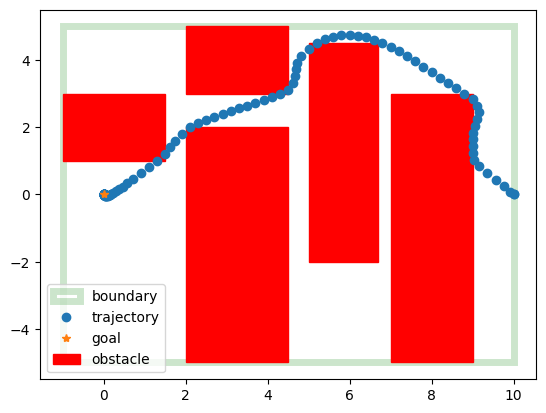

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

figure = plt.figure()

plt.gca().add_patch(Rectangle((-1, -5), 11, 10, linewidth=5.0, ec='g', fc='w', alpha=0.2, label="boundary"))
plt.plot(x_sol[0, :], x_sol[1, :], 'o', label="trajectory")
plt.plot(0.0, 0.0, '*', linewidth=10, label="goal")

for i in range(num_obs):
    if i == 0:
        plt.gca().add_patch(Rectangle((obs_lower[0, i], obs_lower[1, i]), obs_size[0, i], obs_size[1, i], ec='r', fc='r', label="obstacle"))
    else:
        plt.gca().add_patch(Rectangle((obs_lower[0, i], obs_lower[1, i]), obs_size[0, i], obs_size[1, i], ec='r', fc='r'))
plt.legend(loc = 3)
plt.show()